# Computer Vision Lecture - Exercise 2 Part 2 - Stereo

This second part of exercise 2 deals with stereo vision and disparity estimation in particular. Here, you are first going to implement the block matching algorithm as a classical approach using handcrafted similarity measures and visualize the results. Next, we will move on to learned stereo matching using Siamese Neural Networks.

As in the previous exercise, this notebook guides you through the relevant steps. When you see helper functions, you don't need to do anything - they are already implemented. The functions you need to implement are indicated as Exercise Function and where applicable the sections you need to fill in are marked. Sometimes, you can find Hints - these are written upside-down so you can first try to find the solution without reading them.

Happy hacking!

## Preliminaries

Let's first the import relevant libaries, set some hyperparameters like `window_size` and `max_disparity` and load a test set of five stereo image pairs from the KITTI dataset. We'll visualize one of them.

KITTI data loaded (5 images)!


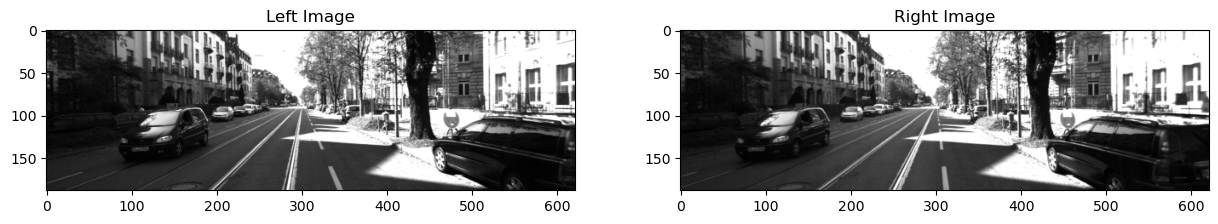

In [1]:
# Uncomment in google colab to extract dataset
# !unzip KITTI_2015_subset.zip

import os
import sys
import argparse
import torch

import numpy as np

from matplotlib import pyplot as plt
from assets.stereo_batch_provider import KITTIDataset, PatchProvider
from scipy.signal import convolve

# Shortcuts
input_dir = './assets/KITTI_2015_subset'
window_size = 3
max_disparity = 50
out_dir = os.path.join(
    './output/handcrafted_stereo', 'window_size_%d' % window_size
)

# Create output directory
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    
# Load dataset
dset = KITTIDataset(os.path.join(input_dir, "data_scene_flow/testing/"))

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121)
ax1.imshow(dset[0][0].squeeze(), cmap='gray')
ax1.title.set_text('Left Image')
ax2 = fig.add_subplot(122)
ax2.imshow(dset[0][1].squeeze(), cmap='gray')
ax2.title.set_text('Right Image')
plt.show()

## Block Matching

In this section we will implement the block matching algorithm for disparity estimation. Similar to the *Sum of Squared Differences (SSD)* metric, which you know from the lecture, we will use the *Sum of Absolute Differences (SAD)*, which is defined as:

$SAD(x, y, d) = |w_{L}(x, y) - w_{R}(x - d, y)|$

where $d$ is in the range of $[0, D]$ and the maximum disparity $D$ is a hyperparameter.

### Exercise 1
In the function skeleton below, implement block matching using *SAD* to compute a disparity map given a stereo image pair, a window size and a maximum disparity. Use the *Winner-Takes-All (WTA)* approach to determine the final disparity for each pixel.

*Hint*: ˙ɥʇpᴉʍ puɐ ʇɥƃᴉǝɥ s’ǝƃɐɯᴉ ǝɥʇ ǝɹɐ ɥʇpᴉʍ puɐ ʇɥƃᴉǝɥ ǝɹǝH ˙lǝxᴉd ɥɔɐǝ ɹoɟ ʎʇᴉɹɐdsᴉp ǝɥʇ ǝʇɐlnɔlɐɔ
oʇ [Ɩ + ǝzᴉs ʍopuᴉʍ − ɥʇpᴉʍ '0] puɐ [Ɩ + ǝzᴉs ʍopuᴉʍ − ʇɥƃᴉǝɥ '0] ɯoɹɟ ƃuᴉƃuɐɹ sdool ɹoɟ pǝʇsǝu oʍʇ
ǝsn uɐɔ noʎ ʇɐɥʇ os sǝƃɐɯᴉ ǝɥʇ oʇ ƃuᴉppɐd oɹǝz ʎlddɐ ǝʍ ʇɐɥʇ ǝǝs uɐɔ noʎ ǝpoɔ ǝɥʇ uᴉ

*Bonus*: Instead, you can also try to implement a more elegant solution where for each candidate disparity value you first compute the absolute difference image and next convolve this image with a mean filter of size `window_size`, using the `scipy.signal.convolve()` function. We provide a bonus function skeleton for this below.

In [2]:
###########################
##### Helper Function #####
###########################
def add_padding(I, padding):
    """
    Adds zero padding to an RGB or grayscale image.

    Args:
        I (np.ndarray): HxWx? numpy array containing RGB or grayscale image
    
    Returns:
        P (np.ndarray): (H+2*padding)x(W+2*padding)x? numpy array containing zero padded image
    """
    if len(I.shape) == 2:
        H, W = I.shape
        padded = np.zeros((H+2*padding, W+2*padding), dtype=np.float32)
        padded[padding:-padding, padding:-padding] = I
    else:
        H, W, C = I.shape
        padded = np.zeros((H+2*padding, W+2*padding, C), dtype=I.dtype)
        padded[padding:-padding, padding:-padding] = I

    return padded


###########################
#### Exercise Function ####
###########################
def sad(image_left, image_right, window_size=3, max_disparity=50):
    """
    Compute the sum of absolute differences between image_left and image_right.

    Args:
        image_left (np.ndarray): HxW numpy array containing grayscale right image
        image_right (np.ndarray): HxW numpy array containing grayscale left image
        window_size: window size (default 3)
        max_disparity: maximal disparity to reduce search range (default 50)
    
    Returns:
        D (np.ndarray): HxW numpy array containing the disparity for each pixel
    """

    D = np.zeros_like(image_left)
    height = image_left.shape[0]
    width = image_left.shape[1]
    # add zero padding
    padding = window_size // 2
    image_left = add_padding(image_left, padding).astype(np.float32)
    image_right = add_padding(image_right, padding).astype(np.float32)

    for y in range(height):
        for x in range(width):
            # 左边图像的窗口
            window_left = image_left[y:y + window_size, x:x + window_size]
            best_disparity = 0
            min_sad = float('inf')
            for d in range(max_disparity):
                if x - d < 0:
                    continue
                # 一定是减去d，因为右边图像是左边图像向右平移d个像素
                window_right = image_right[y:y + window_size, x - d:x - d + window_size]
                now_sad = np.sum(np.abs(window_left - window_right))

                if now_sad < min_sad:
                    min_sad = now_sad
                    best_disparity = d

            # 保存SAD
            D[y, x] = best_disparity

    return D


###########################
##### Bonus Function #####
###########################
def sad_convolve(image_left, image_right, window_size=3, max_disparity=50):
    """
    Compute the sum of absolute differences between image_left and image_right
    by using a mean filter.

    Args:
        image_left (np.nfarray): HxW numpy array containing grayscale right image
        image_right (np.nfarray): HxW numpy array containing grayscale left image
        window_size: window size (default 3)
        max_disparity: maximal disparity to reduce search range (default 50)
    
    Returns:
        D (np.ndarray): HxW numpy array containing the disparity for each pixel
    """
    #######################################
    padding = window_size // 2
    image_left = add_padding(image_left, padding).astype(np.float32)
    image_right = add_padding(image_right, padding).astype(np.float32)
    SAD = np.zeros((image_left.shape[0], image_left.shape[1], max_disparity + 1))

    kernel = np.ones((window_size, window_size)) / (window_size ** 2)

    for d in range(0, max_disparity + 1):
        if d == 0:
            right_shifted = image_right
        else:
            right_shifted = np.zeros_like(image_right)
            right_shifted[:, d:] = image_right[:, :-d]

        img_diff = np.abs(image_left - right_shifted)
        img_sad = convolve(img_diff, kernel, mode='same')  # 通过卷积运算，可以计算出每个像素邻域的总差异，也就是SAD值
        SAD[:, :, d] = img_sad

    D = np.argmin(SAD, axis=2)
    return D


### Exercise 2

To check if our computed disparity is sensible it's always a good idea to visualize the results. Implement a function in the skeleton below that plots both the estimated disparity map as well as one of the input images.

Remark: *In case you end up using matplotlib for your visualizations, keep in mind that you might have to
properly adjust the figure size and the v min and v max arguments of the imshow() function in order
to get nice results.*

In [3]:
###########################
#### Exercise Function ####
###########################
def visualize_disparity(disparity, im_left, im_right, title='Disparity Map', max_disparity=50):
    """
    Generates a visualization for the disparity map.

    Args:
        disparity (np.array): disparity map
        title: plot title
        out_file: output file path
        max_disparity: maximum disparity
    """
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(im_left.squeeze(), cmap='gray')
    ax1.title.set_text('Left Image')
    ax2 = fig.add_subplot(122)
    ax2.imshow(disparity.squeeze(), cmap='jet', vmax=max_disparity)
    ax2.title.set_text(title)
    plt.show()

Great! Let's compute the disparities for our dataset and see how they look! This might take up to several minutes per scene depending on your hardware. If you implemented the bonus function you can replace 'sad()' with 'sad_convolve()' below, which should bring a significant speed up.

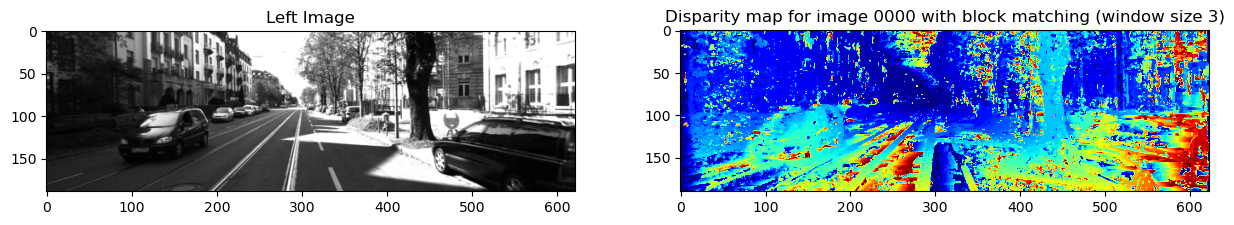

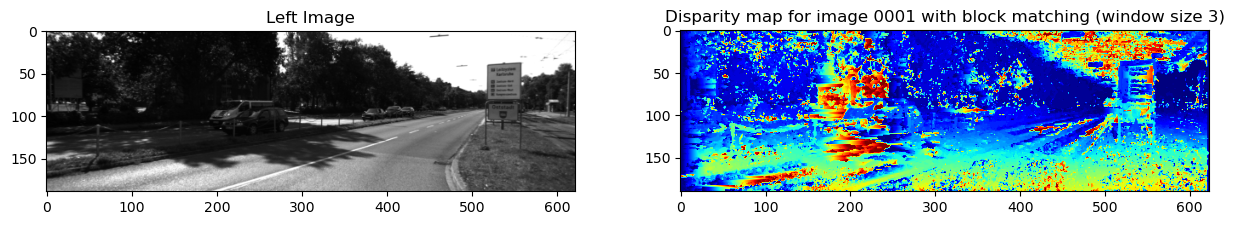

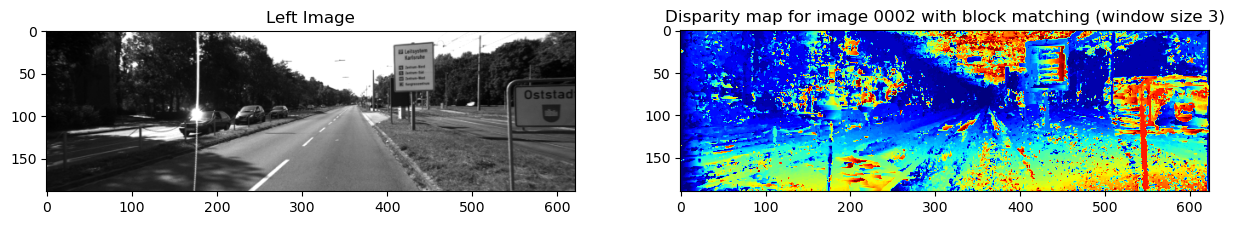

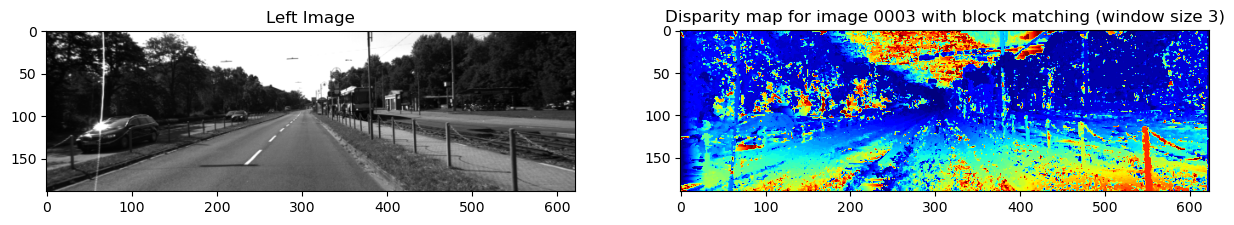

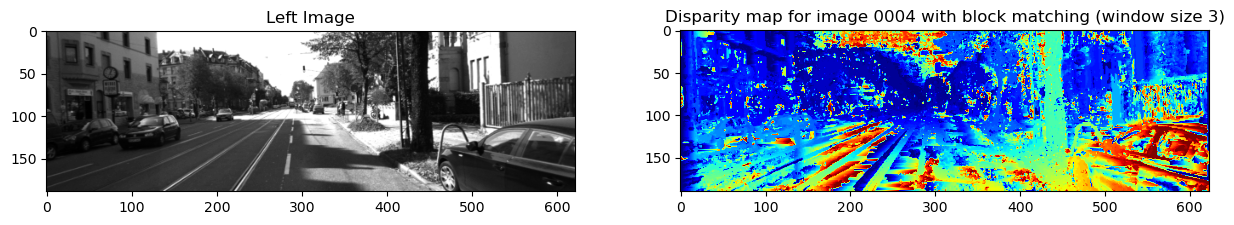

In [4]:
for i in range(len(dset)):
        # Load left and right images
        im_left, im_right  = dset[i]
        im_left, im_right = im_left.squeeze(-1), im_right.squeeze(-1)

        # Calculate disparity
        D = sad_convolve(im_left, im_right, window_size=window_size, max_disparity=max_disparity)

        # Define title for the plot
        title = 'Disparity map for image %04d with block matching (window size %d)' % (i, window_size)
        # Define output file name and patch
        file_name = '%04d_w%03d.png' % (i, window_size)
        out_file_path = os.path.join(out_dir, file_name)

        # Visualize the disparty and save it to a file
        visualize_disparity(D, im_left, im_right, title=title, max_disparity=max_disparity)

## Exercise 3
Experiment with the different window sizes {3, 7, 15} and report which one leads to better visual results and why? (You can open the plots in new tabs to retain old results when you re-run the cell. In case you were not able to solve the previous exercises, you can use the provided disparity maps in the examples/ folder.)

## Exercise 4
Why do you think the block matching approach fails to lead to good estimations around homogeneous regions such as the road?


## Siamese Neural Networks

In this section we again estimate the disparity for all the stereo pairs in the test set but this time
using a Siamese Neural Network which will learn the task from data. The key idea is to train the network
to estimate the similarity between two patches. We do this by first extracting features in a convolutional
manner and then normalizing the per-pixel feature vectors and calculating the dot product.

### Exercise 5

Let's start by building our Siamese Neural Network. Using the `torch.nn` library, fill in the missing code in the PyTorch Module skeleton `class StereoMatchingNetwork(torch.nn.module)` provided below for both the `def __init__(self)` and `def forward(self, X)` methods to define the architecture. It should consist of the following:

- `Conv2d(..., out_channels=64, kernel_size=3)`
- `ReLU()`
- `Conv2d(..., out_channels=64, kernel_size=3)`
- `ReLU()`
- `Conv2d(..., out_channels=64, kernel_size=3)`
- `ReLU()`
- `Conv2d(..., out_channels=64, kernel_size=3)`
- `functional.normalize(..., dim=1, p=2)`

The `def forward(self, X)` method should then perform one forward pass through those layers. Be aware that the layers form only one of the two identical branches of the siamese network. The forward pass will be called twice, that ensures weight sharing between both branches of the siamese network.

Remark: *Note that the convolutional layers expect the data to have shape batch size × channels ×
height × width. Permute the input dimensions accordingly for the convolutions and remember to
revert it before returning the features.*

In [5]:
###########################
#### Exercise Function ####
###########################
class StereoMatchingNetwork(torch.nn.Module):
    def __init__(self):
        """
        Implementation of the network layers.
        Layer output tensor size: (batch_size, n_features, height - 8, width - 8)
        """
        super().__init__()
        gpu = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.conv1 = torch.nn.Conv2d(1, 64, 3)
        self.conv2 = torch.nn.Conv2d(64, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 64, 3)
        self.conv4 = torch.nn.Conv2d(64, 64, 3)

        # Hint: Don't forget to move the modules to the gpu
        self.to(gpu)


    def forward(self, X):
        """ 
        The forward pass of the network. Returns the features for a given image patch.

        Args:
            X (torch.Tensor): image patch of shape (batch_size, height, width, n_channels)

        Returns:
            features (torch.Tensor): predicted normalized features of the input image patch X,
                               shape (batch_size, height - 8, width - 8, n_features)
        """

        import torch.nn.functional as f
        X = X.permute(0, 3, 1, 2)

        X = self.conv1(X)
        X = f.relu(X)
        X = self.conv2(X)
        X = f.relu(X)
        X = self.conv3(X)
        X = f.relu(X)
        X = self.conv4(X)
        X = f.relu(X)

        X = f.normalize(X)
        X = X.permute(0, 2, 3, 1)
        features = X
        
        return features

### Exercise 6

From the lecture you know two classes of Siamese Neural Network architectures - which class does this architecture belong to?

### Exercise 7

Next, we need a way to compute a similarity score from the features extracted by the Siamese Neural Network. In the skeleton below, implement a function which takes an instance of the `StereoMatchingNetwork(torch.nn.Module)` class, as well as a pair of patches from the left and right image as input and estimates their similarity.

*Hint 1*: ˙ sɹosuǝʇ ǝɹnʇɐǝɟ ǝsǝɥʇ uǝǝʍʇǝq ʎʇᴉɹɐlᴉɯᴉs ǝɥʇ ǝʇɐlnɔlɐɔ uǝɥ┴ ˙ʞɹoʍʇǝu ǝsǝɯɐᴉS ǝɥʇ ɟo ɥɔuɐɹq ɥɔɐǝ ɟo sɹosuǝʇ ǝɹnʇɐǝɟ ǝɥʇ ǝʇɐɯᴉʇsǝ oʇ sɹosuǝʇ oʍʇ ǝɥʇ ɟo ɥɔɐǝ uo ssɐd pɹɐʍɹoɟ ǝɥʇ unɹ 'ʇsɹᴉℲ

*Hint 2*: ˙ʇɔnpoɹd ʇop ǝɥʇ ƃuᴉʇɐlnɔlɐɔ ʎq ʎʇᴉɹɐlᴉɯᴉs ǝɥʇ uᴉɐʇqo noʎ 'pǝzᴉlɐɯɹou ʎpɐǝɹlɐ ǝɹɐ sɹosuǝʇ ǝɹnʇɐǝɟ ǝɥʇ s∀

In [6]:
###########################
#### Exercise Function ####
###########################
def calculate_similarity_score(infer_similarity_metric, Xl, Xr):
    """
    Computes the similarity score for two stereo image patches.

    Args:
        infer_similarity_metric (torch.nn.Module):  pytorch module object
        Xl (torch.Tensor): tensor holding the left image patch
        Xr (torch.Tensor): tensor holding the right image patch

    Returns:
        score (torch.Tensor): the similarity score of both image patches which is the dot product of their features
    """
    l_features = infer_similarity_metric(Xl)
    r_features = infer_similarity_metric(Xr)

    score = torch.sum(l_features * r_features, dim=-1).squeeze()

    return score

Great! As of now, the network's weights are randomly initialized. In order for it to compute useful features we need to train it for the task. For this we need a loss function to quantify how well the network performs at the task and a training loop to run the optimization to minimize that loss function. Both are provided as helper functions below.

In [7]:
###########################
##### Helper Function #####
###########################
def hinge_loss(score_pos, score_neg, label):
    """
    Computes the hinge loss for the similarity of a positive and a negative example.

    Args:
        score_pos (torch.Tensor): similarity score of the positive example
        score_neg (torch.Tensor): similarity score of the negative example
        label (torch.Tensor): the true labels

    Returns:
        avg_loss (torch.Tensor): the mean loss over the patch and the mini batch
        acc (torch.Tensor): the accuracy of the prediction
    """
    # Calculate the hinge loss max(0, margin + s_neg - s_pos)
    loss = torch.max(0.2 + score_neg - score_pos, torch.zeros_like(score_pos))

    # Obtain the mean over the patch and the mini batch
    avg_loss = torch.mean(loss)

    # Calculate the accuracy
    similarity = torch.stack([score_pos, score_neg], dim=1)
    labels = torch.argmax(label, dim=1)
    predictions = torch.argmax(similarity, dim=1)
    acc = torch.mean((labels == predictions).float())

    return avg_loss, acc


###########################
##### Helper Function #####
###########################
def training_loop(infer_similarity_metric, patches, optimizer, iterations=1000, batch_size=128):
    '''
    Runs the training loop of the siamese network.
    
    Args:
        infer_similarity_metric (obj): pytorch module
        patches (obj): patch provider object
        optimizer (obj): optimizer object
        iterations (int): number of iterations to perform
        batch_size (int): batch size
    '''

    loss_list = []
    try:
        print("Starting training loop.")
        for idx, batch in zip(range(iterations), patches.iterate_batches(batch_size)):
            # Extract the batches and labels
            Xl, Xr_pos, Xr_neg = batch
            # uncomment if you don't have a gpu
            # Xl, Xr_pos, Xr_neg = Xl.cpu(), Xr_pos.cpu(), Xr_neg.cpu()
            
            # use this line if you have a gpu
            label = torch.eye(2).cuda()[[0]*len(Xl)]  # label is always [1, 0]
            # use this line if you don't have a gpu
            # label = torch.eye(2)[[0]*len(Xl)]  # label is always [1, 0]

            # calculate the similarity score
            score_pos = calculate_similarity_score(infer_similarity_metric, Xl, Xr_pos)
            score_neg = calculate_similarity_score(infer_similarity_metric, Xl, Xr_neg)
            # compute the loss and accuracy
            loss, acc = hinge_loss(score_pos, score_neg, label)

            # compute the gradients
            optimizer.zero_grad()
            loss.backward()
            # let the optimizer perform one step and update the weights
            optimizer.step()

            # Append loss to list
            loss_list.append(loss.item())

            if idx % 50 == 0:
                print("Loss (%04d it):%.04f \tAccuracy: %0.3f" % (idx, loss, acc))
    finally:
        patches.stop()
        print("Finished training!")

Let's run the training! For this we provide a separate training dataset. Depending on your hardware this may take a few minutes! If you don't have access to a GPU, you can uncomment the indicated lines in the training loop helper function as well as the training code below to run the training on the CPU. Note that this will be significantly slower.

## Exercise 8

Try to improve the network by finding better hyperparameters. For example, you can vary the number of training iterations or the number of filters in the convolutional layers. Explain your findings.

In [8]:
# Fix random seed for reproducibility        
np.random.seed(7)
torch.manual_seed(7)

# Shortcuts for directories
model_out_dir = os.path.join(out_dir, 'model')
model_file = os.path.join(model_out_dir, "model.t7")

# Hyperparameters
training_iterations = 1000
batch_size= 128
learning_rate = 3e-4
patch_size = 9
padding = patch_size // 2
max_disparity = 50

# Check if output directory exists and if not create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

# Create dataloader for KITTI training set
dataset = KITTIDataset(
    os.path.join(input_dir, "data_scene_flow/training/"),
    os.path.join(input_dir, "data_scene_flow/training/disp_noc_0"),
)
# Load patch provider
patches = PatchProvider(dataset, patch_size=(patch_size, patch_size))

# Initialize the network
infer_similarity_metric = StereoMatchingNetwork()
# Set to train
infer_similarity_metric.train()
# uncomment if you don't have a gpu
# infer_similarity_metric.to('cpu')
optimizer = torch.optim.SGD(infer_similarity_metric.parameters(), lr=learning_rate, momentum=0.9)

# Start training loop
training_loop(infer_similarity_metric, patches, optimizer,
                iterations=1000, batch_size=128)

KITTI data loaded (30 images)!
Starting training loop.
Loss (0000 it):0.1893 	Accuracy: 0.828
Loss (0050 it):0.1825 	Accuracy: 0.836
Loss (0100 it):0.1278 	Accuracy: 0.844
Loss (0150 it):0.1607 	Accuracy: 0.758
Loss (0200 it):0.1489 	Accuracy: 0.789
Loss (0250 it):0.1674 	Accuracy: 0.852
Loss (0300 it):0.1859 	Accuracy: 0.844
Loss (0350 it):0.1292 	Accuracy: 0.859
Loss (0400 it):0.1338 	Accuracy: 0.883
Loss (0450 it):0.1994 	Accuracy: 0.852
Loss (0500 it):0.1992 	Accuracy: 0.852
Loss (0550 it):0.1993 	Accuracy: 0.852
Loss (0600 it):0.1987 	Accuracy: 0.914
Loss (0650 it):0.1990 	Accuracy: 0.859
Loss (0700 it):0.1988 	Accuracy: 0.852
Loss (0750 it):0.1992 	Accuracy: 0.828
Loss (0800 it):0.1985 	Accuracy: 0.875
Loss (0850 it):0.1987 	Accuracy: 0.836
Loss (0900 it):0.1982 	Accuracy: 0.859
Loss (0950 it):0.1973 	Accuracy: 0.891
Finished training!


As a last building block, we need a way to compute disparity maps from the network's outputs. This is implemented in the helper function below.

In [9]:
###########################
##### Helper Function #####
###########################
def compute_disparity_CNN(infer_similarity_metric, img_l, img_r, max_disparity=50):
    """
    Computes the disparity of the stereo image pair.

    Args:
        infer_similarity_metric:  pytorch module object
        img_l: tensor holding the left image
        img_r: tensor holding the right image
        max_disparity (int): maximum disparity

    Returns:
        D: tensor holding the disparity
    """
    # get the image features by applying the similarity metric
    Fl = infer_similarity_metric(img_l[None])
    Fr = infer_similarity_metric(img_r[None])

    # images of shape B x H x W x C
    B, H, W, C = Fl.shape
    # Initialize the disparity
    disparity = torch.zeros((B, H, W)).int()
    # Initialize current similarity to -infimum
    current_similarity = torch.ones((B, H, W)) * -np.inf

    # Loop over all possible disparity values
    Fr_shifted = Fr
    for d in range(max_disparity + 1):
        if d > 0:
            # initialize shifted right image
            Fr_shifted = torch.zeros_like(Fr)
            # insert values which are shifted to the right by d
            Fr_shifted[:, :, d:] = Fr[:, :, :-d]

        # Calculate similarities
        sim_d = torch.sum(Fl * Fr_shifted, dim=3)
        # Check where similarity for disparity d is better than current one
        indices_pos = sim_d > current_similarity
        # Enter new similarity values
        current_similarity[indices_pos] = sim_d[indices_pos]
        # Enter new disparity values
        disparity[indices_pos] = d

    return disparity

Great! Now that we have fitted a model that can estimate disparity from a pair of stereo images. Let's see how well it performs on the test set by visualizing the disparity maps.

## Exercise 9

Compare the visualization of the disparity maps from the Siamese Neural Network to the ones obtained by the block matching algorithm. Which predictions are better and why? Can you find regions in the scenes where the differences in predictions are most dominant? (If you were not able to solve the previous exercises, you can use the provided disparity maps in the examples/ folder.)


KITTI data loaded (5 images)!
Processing 0 image


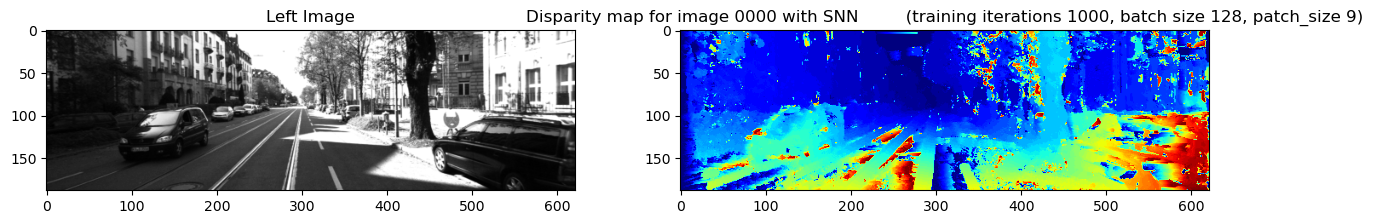

Processing 1 image


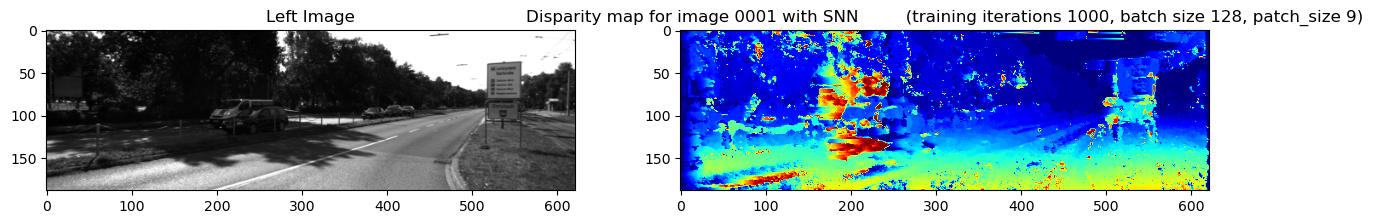

Processing 2 image


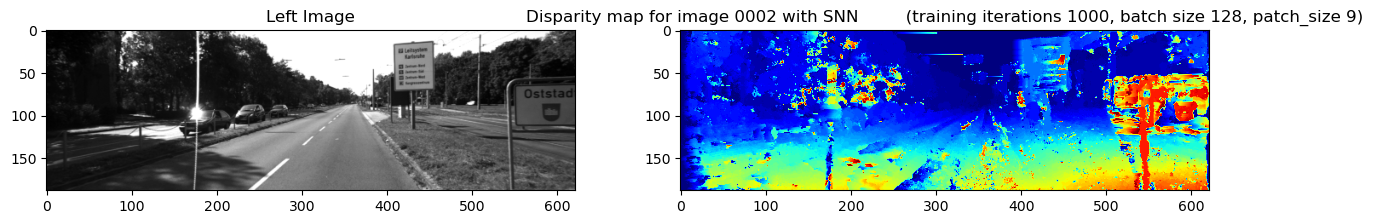

Processing 3 image


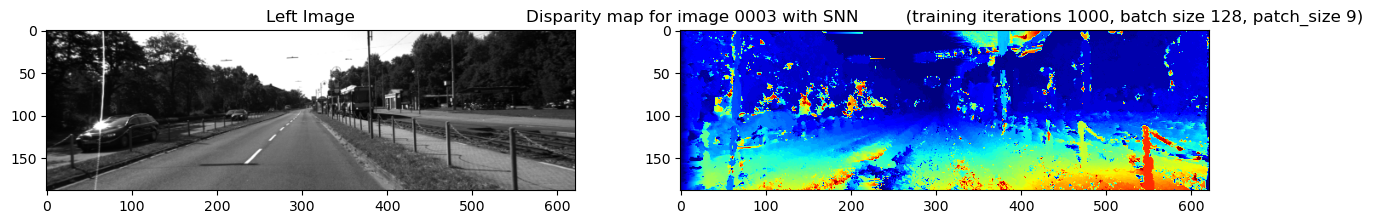

Processing 4 image


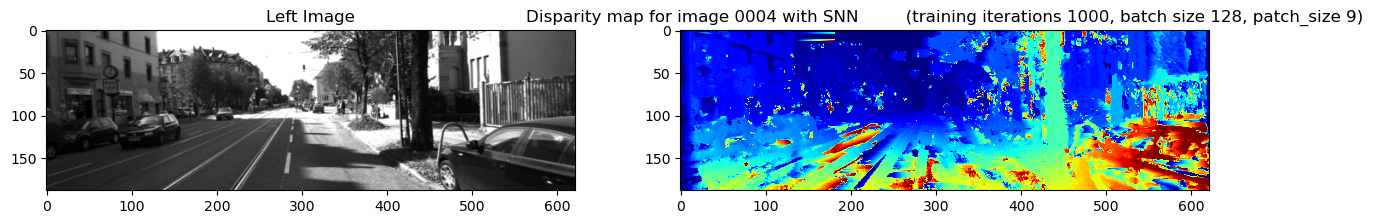

In [10]:
# Set network to eval mode
infer_similarity_metric.eval()
infer_similarity_metric.to('cpu')

# Load KITTI test split
dataset = KITTIDataset(os.path.join(input_dir, "data_scene_flow/testing/"))
# Loop over test images
for i in range(len(dataset)):
    print('Processing %d image' % i)
    # Load images and add padding
    img_left, img_right = dataset[i]
    img_left_padded, img_right_padded = add_padding(img_left, padding), add_padding(img_right, padding)
    img_left_padded, img_right_padded = torch.Tensor(img_left_padded), torch.Tensor(img_right_padded)

    disparity_map = compute_disparity_CNN(
        infer_similarity_metric, img_left_padded, img_right_padded, max_disparity=max_disparity
    )
    # Define title for the plot
    title = 'Disparity map for image %04d with SNN \
        (training iterations %d, batch size %d, patch_size %d)' % (i, training_iterations, batch_size, patch_size)
    visualize_disparity(disparity_map.squeeze(), img_left.squeeze(), img_right.squeeze(), title, max_disparity=max_disparity)
